#Imports and helper functions

In [93]:
import numpy as np
np.random.seed(69)  # for reproducibility
import h5py

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers import GlobalAveragePooling2D,MaxPool2D,GlobalAveragePooling3D,AveragePooling3D,ConvLSTM2D,TimeDistributed, Reshape, Input, Dense, Dropout, Flatten, Conv3D, MaxPooling3D,Conv2D, MaxPooling2D,BatchNormalization,AveragePooling2D, concatenate
from keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.initializers import TruncatedNormal,Constant
from tqdm.keras import TqdmCallback


from os import system
from os.path import exists
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
MyDrive  Othercomputers


In [64]:
model_dir = 'gdrive/MyDrive/Classes/Fall21/PHY7097\ ML/Final\ Project/model'

In [27]:
!mkdir Particle_Images
!cd Particle_Images
!mkdir data/

In [54]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://github.com/ekoenig4/ParticleImages/blob/Evan/models/bearnet-truncated/history.pkl
!wget https://github.com/ekoenig4/ParticleImages/blob/Evan/models/bearnet-truncated/saved_model.pb

--2021-11-30 14:51:58--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 188.184.97.72, 137.138.120.151, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|188.184.97.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82.98M  21.5MB/s    in 3.9s    

Last-modified header invalid -- time-stamp ignored.
2021-11-30 14:52:04 (21.5 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2021-11-30 14:52:04--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 188.184.97.72, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|188.184.97.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391 (76

In [50]:
!apt install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

In [53]:
!svn checkout https://github.com/ekoenig4/ParticleImages/tree/Evan/models/bearnet-truncated

svn: E170000: URL 'https://github.com/ekoenig4/ParticleImages/tree/Evan/models/bearnet-truncated' doesn't exist


In [29]:
import pickle
#with open('history.pkl','rb') as f_history: history = pickle.load(f_history)

In [30]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

In [31]:
lr_init     = 1.e-3    # Initial learning rate 
batch_size  = 100       # Batch size
train_size  = 4000     # Training size 
valid_size  = 2000     # Validation size
test_size   = 2000     # Test size

In [32]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)
y_b_train = to_categorical(y_train)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)
y_b_valid = to_categorical(y_valid)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)
y_b_test = to_categorical(y_test)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

In [95]:
def naive_inception(input,filter_sizes=[40,60,80]):
  """
  input: previous layer's output
  filter_sizes: sizes of kernels (1x1,2x2,3x3)
  returns inception layer
  """
  #1x1 convolution
  layer_1 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(input)
  #2x2 convolution
  layer_2 = Conv2D(filters=filter_sizes[1], 
                  activation='relu', 
                  kernel_size=2,
                  padding='same')(input)
  #3x3 convolution
  layer_3 = Conv2D(filters=filter_sizes[2], 
                  activation='relu', 
                  kernel_size=3,
                  padding='same')(input)
  #2x2 max pooling
  layer_4 = AveragePooling2D(pool_size=2,strides=1,
                             padding='same')(input)

  mid_1 = concatenate([layer_1, layer_2, layer_3, layer_4], axis = 3)
  return mid_1

def inception(input,filter_sizes=[60,50,40]):
  """
  input: previous layer's output
  filter_sizes: sizes of kernels (1x1,2x2,3x3)
  returns inception layer
  """
  #1x1 convolution
  layer_1 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(input)
  #2x2 convolution
  layer_2 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(input)
  layer_2 = Conv2D(filters=filter_sizes[1], 
                  activation='relu', 
                  kernel_size=2,
                  padding='same')(layer_2)
        
  #3x3 convolution
  layer_3 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(input)
  layer_3 = Conv2D(filters=filter_sizes[2], 
                  activation='relu', 
                  kernel_size=3,
                  padding='same')(layer_3)
  #2x2 max pooling
  layer_4 = MaxPooling2D(pool_size=2,strides=1,
                             padding='same')(input)
  layer_4 = Conv2D(filters=filter_sizes[0], 
                  activation='relu', 
                  kernel_size=1,
                  padding='same')(layer_4)

  mid_1 = concatenate([layer_1, layer_2, layer_3, layer_4], axis = 3)
  #mid_1 = concatenate([layer_2, layer_3, layer_4], axis = 3)
  return mid_1

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output
def inception_module_b(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [ ]:
def googlenet(input):
  x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2')(input)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
  x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
  x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

  x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')
  x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
  x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


  x1 = AveragePooling2D((5, 5), strides=3)(x)
  x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
  x1 = Flatten()(x1)
  x1 = Dense(1024, activation='relu')(x1)
  x1 = Dropout(0.7)(x1)
  x1 = Dense(2, activation='softmax', name='auxilliary_output_1')(x1)

  x = inception_module(x,
                      filters_1x1=160,
                      filters_3x3_reduce=112,
                      filters_3x3=224,
                      filters_5x5_reduce=24,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4b')

  x = inception_module(x,
                      filters_1x1=128,
                      filters_3x3_reduce=128,
                      filters_3x3=256,
                      filters_5x5_reduce=24,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4c')

  x = inception_module(x,
                      filters_1x1=112,
                      filters_3x3_reduce=144,
                      filters_3x3=288,
                      filters_5x5_reduce=32,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4d')


  x2 = AveragePooling2D((5, 5), strides=3)(x)
  x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
  x2 = Flatten()(x2)
  x2 = Dense(1024, activation='relu')(x2)
  x2 = Dropout(0.7)(x2)
  x2 = Dense(2, activation='softmax', name='auxilliary_output_2')(x2)

  x = inception_module(x,
                      filters_1x1=256,
                      filters_3x3_reduce=160,
                      filters_3x3=320,
                      filters_5x5_reduce=32,
                      filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_4e')

  x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

  x = inception_module(x,
                      filters_1x1=256,
                      filters_3x3_reduce=160,
                      filters_3x3=320,
                      filters_5x5_reduce=32,
                      filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_5a')

  x = inception_module(x,
                      filters_1x1=384,
                      filters_3x3_reduce=192,
                      filters_3x3=384,
                      filters_5x5_reduce=48,
                      filters_5x5=128,
                      filters_pool_proj=128,
                      name='inception_5b')

  x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
  x = Dropout(0.4)(x)

  x = Flatten()(x)
  x = Dropout(0.4)(x)
  x = Dense(1000,activation='relu')(x)
  x = Dense(2, activation='softmax', kernel_initializer='TruncatedNormal')(x)
  model = Model(input, [x, x1, x2], name='inception_v1')
  return model
#model.summary()

In [ ]:
def bearnet(input):
  x = Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', name='conv_1_3x3')(input)
  x = MaxPool2D((2, 2), padding='same', strides=2, name='max_pool_1_3x3')(x)
  x = Conv2D(32, (2, 2), padding='same', strides=(1, 1), activation='relu', name='conv_2a_2x2')(x)
  x = Conv2D(96, (2, 2), padding='same', strides=(1, 1), activation='relu', name='conv_2b_2x2')(x)
  x = MaxPool2D((2, 2), padding='same', strides=1, name='max_pool_2_2x2/2')(x)

  x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=48,
                     filters_3x3=64,
                     filters_5x5_reduce=16,
                     filters_5x5=16,
                     filters_pool_proj=16,
                     name='inception_3a')
  x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=64,
                     filters_3x3=96,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=32,
                     name='inception_3b')

  x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_3_2x2/2')(x)
  x = inception_module(x,
                     filters_1x1=96,
                     filters_3x3_reduce=48,
                     filters_3x3=104,
                     filters_5x5_reduce=16,
                     filters_5x5=24,
                     filters_pool_proj=32,
                     name='inception_4a')


  x1 = AveragePooling2D((2, 2), strides=2)(x)
  x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
  x1 = Flatten()(x1)
  x1 = Dense(1024, activation='relu')(x1)
  x1 = Dropout(0.4)(x1)
  x1 = Dense(2, activation='softmax', name='auxilliary_output_1')(x1)

  x = inception_module(x,
                      filters_1x1=80,
                      filters_3x3_reduce=56,
                      filters_3x3=112,
                      filters_5x5_reduce=12,
                      filters_5x5=32,
                      filters_pool_proj=32,
                      name='inception_4b')

  x = inception_module(x,
                      filters_1x1=64,
                      filters_3x3_reduce=64,
                      filters_3x3=128,
                      filters_5x5_reduce=12,
                      filters_5x5=32,
                      filters_pool_proj=32,
                      name='inception_4c')

  x = inception_module(x,
                      filters_1x1=56,
                      filters_3x3_reduce=72,
                      filters_3x3=144,
                      filters_5x5_reduce=16,
                      filters_5x5=32,
                      filters_pool_proj=32,
                      name='inception_4d')


  x2 = AveragePooling2D((2,2), strides=2)(x)
  x2 = Conv2D(64, (1, 1), padding='same', activation='relu')(x2)
  x2 = Flatten()(x2)
  x2 = Dense(1024, activation='relu')(x2)
  x2 = Dropout(0.4)(x2)
  x2 = Dense(2, activation='softmax', name='auxilliary_output_2')(x2)

  x = inception_module(x,
                      filters_1x1=128,
                      filters_3x3_reduce=80,
                      filters_3x3=160,
                      filters_5x5_reduce=16,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_4e')

  x = MaxPool2D((2, 2), padding='same', strides=(2,2), name='max_pool_4_2x2/1')(x)

  x = inception_module(x,
                      filters_1x1=128,
                      filters_3x3_reduce=80,
                      filters_3x3=160,
                      filters_5x5_reduce=16,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_5a')

  x = inception_module(x,
                      filters_1x1=192,
                      filters_3x3_reduce=96,
                      filters_3x3=192,
                      filters_5x5_reduce=24,
                      filters_5x5=64,
                      filters_pool_proj=64,
                      name='inception_5b')

  #x = GlobalAveragePooling2D(name='avg_pool_5_2x2/1')(x)
  #x = Dropout(0.4)(x)

  x = Flatten()(x)
  x = Dropout(0.4)(x)
  x = Dense(1000,activation='relu')(x)
  x = Dense(2, activation='softmax', kernel_initializer='TruncatedNormal')(x)
  model = Model(input, [x, x1, x2], name='inception_v1')
  return model
#model.summary()

In [87]:
def plot_history(history,metric='loss',save=False,fname=''):
    loss = history[metric]
    val_loss = history[f'val_{metric}']
    
    plt.plot(loss,label='Training')
    plt.plot(val_loss,label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    if save:
        save_plot(fname)
        plt.close()
    else:
        plt.show()
def plot_roc(y_true, y_pred,save=False,fname=''):
    """Plot ROC Curve
    Args:
        y_true (numpy.array): array of true labels
        y_pred (numpy.array): array of predicted labels
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    line = [0,1]
    fig = plt.figure()
    plt.plot(line,line,'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC = {auc:.3f})')
    if save:
        save_plot(fname) 
    else:
        plt.show()
def plot_avgtcdecomposition(avg_tc,figtitle='None'):
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
  fig.set_figheight(4)
  fig.set_figwidth(12)
  fig.suptitle(figtitle)
  ax1.imshow(avg_tc[:,:,0])
  ax1.set(xlabel='x',ylabel='y')

  ax2.imshow(avg_tc[:,:,1])
  ax2.set(xlabel='t',ylabel='x')

  ax3.imshow(avg_tc[:,:,2])
  ax3.set(xlabel='t',ylabel='y')
def plot_tcdecomposition(tc,figtitle='None',event=0):
  fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
  fig.set_figheight(4)
  fig.set_figwidth(12)
  fig.suptitle(f'{figtitle} Event: {event}')
  ax1.imshow(tc[event,:,:,0])
  ax1.set(xlabel='x',ylabel='y')

  ax2.imshow(tc[event,:,:,1])
  ax2.set(xlabel='t',ylabel='x')

  ax3.imshow(tc[event,:,:,2])
  ax3.set(xlabel='t',ylabel='y')

def timeordered_BC(X,cumulative=False,cutoff=0.,remove_empty=True,normalize=False,min_t = -0.05,max_t = 0.05,t_step=0.0099):
    """
    X: Image dataset of 32x32 pixels
    cumulative: Keep earlier hits in later time slices
    normalize: Max pixel is 1
    min/max_t: min and max time to consider (elimnate noise and empty data)
    t_step: time step 
    """
    if remove_empty:
        X = remove_empty_pixels(X)
    X_e,X_t = X[:,:,:,0],X[:,:,:,1] #Decompose energy and time
    n_images,width,height,channels = X.shape #Find shape of images
    t_bins = np.arange(min_t, max_t, t_step) #Bin separation for images
    t_mats = [np.full(shape=(width,height),fill_value=t) for t in t_bins]
    max_frames = len(t_mats)
    X_e_timeordered = np.zeros(shape=(n_images,max_frames,width,height))
    X_t_timeordered = np.zeros(shape=(n_images,max_frames,width,height))
    X_e_max = np.zeros(shape=(n_images,width,height))
    X_t_max = np.zeros(shape=(n_images,width,height))
    for i in range(n_images):
        counts = [] #Keep track of number of nonzero pixels in each frame
        for t in range(max_frames-1):
            lower = X[i,:,:,1] > t_mats[t] #Lower bound
            upper = X[i,:,:,1] <= t_mats[t+1] #Upper bound
            is_between = np.logical_and(lower,upper) #Between upper and lower
            counts.append(np.count_nonzero(is_between))
            X_e_timeordered[i,t,:,:] = np.where(~is_between,np.nan,X_e[i,:,:])
            X_t_timeordered[i,t,:,:] = np.where(~is_between,np.nan,X_t[i,:,:])
            index = np.argmax(counts) #Index of max counts
            X_e_max[i,:,:] = X_e_timeordered[i,index,:,:]
            X_t_max[i,:,:] = X_t_timeordered[i,index,:,:]


    #did it work
    cutoff_mat = np.full(X_e_timeordered.shape,cutoff)
    X_e_timeordered = np.where(X_e_timeordered >= cutoff_mat,X_e_timeordered,0.)
    
        
    if remove_empty:
        X_e_timeordered = np.where(
            np.isnan(X_e_timeordered), 0, X_e_timeordered)
    if normalize:
        X_e_timeordered = X_e_timeordered/np.nanmax(X_e_timeordered)
    return X_e_timeordered,X_t_timeordered,max_frames,t_bins,X_e_max,X_t_max
def remove_empty_pixels(X):
    e_X = np.where(X[:,:,:,0] == 0,np.nan,X[:,:,:,0])
    t_X = np.where(X[:,:,:,0] == 0,np.nan,X[:,:,:,1])
    X = np.concatenate([e_X[:,:,:,None],t_X[:,:,:,None]],axis=-1)
    return X
channelMap = {0:'Energy',1:'Time'}
decayMap = {0:'Photon',1:'Electron'}


In [83]:
def plot_spacetime(X, y, event=0, azim=0, elev=0, lo=0, interactive=False):
    """Plot 3D spacetime of specified event
    Args:
        X (numpy.array): array of collider images, shape(-1,32,32,2)
        y (numpy.array): array of collider image labels: Photon = 0, Electron = 1
        event (int, optional): index of event to plot. Defaults to 0.
    """
    index_map = np.indices((32, 32))

    X = remove_empty_pixels(X)

    decay = decayMap[y[event]]
    x = index_map[0][~np.isnan(X[event, :, :, 1])]
    y = index_map[1][~np.isnan(X[event, :, :, 1])]
    z = X[event, :, :, 1][~np.isnan(X[event, :, :, 1])]
    c = X[event, :, :, 0][~np.isnan(X[event, :, :, 1])]
    fig = plt.figure(figsize=(8,8))

    if interactive:
        ax = Axes3D(fig)
    else:
        ax = plt.axes(projection="3d")

    # Creating plot
    sc = ax.scatter(x, y, z, s=1000*c, alpha=0.5, c=c)
    ax.set_xlim(10, 20)
    ax.set_ylim(10, 20)
    ax.set_zlim(-0.015,0.01)
    ax.set(xlabel='X', ylabel='Y', zlabel='Time')
    ax.view_init(azim=azim, elev=elev)
    ax.set_title(f'{decay}')
    # fig.colorbar(sc)
    return fig,ax

In [ ]:
ph_X_mean = np.nanmean(X_train[y_train == 0],axis=0).reshape(1,32,32,2)
el_X_mean = np.nanmean(X_train[y_train == 1],axis=0).reshape(1,32,32,2)

In [84]:
def plot_event(X,y,event=0,channel=-1):
    if channel == -1: channels = [0,1]
    else: channels = [channel]

    fig,axs = plt.subplots(nrows=1,ncols=len(channels),figsize=(12,5))

    decay = decayMap[y[event]]
    if len(channels) == 1:
        im = axs.imshow(X[event,:,:,channel])
        axs.set_title(channelMap[channel])
        axs.grid(True)
        fig.colorbar(im,ax=axs)

    else:
        for i,channel in enumerate(channels):
            im = axs[i].imshow(X[event,:,:,channel])
            axs[i].set_title(channelMap[channel])
            axs[i].grid(True)   
            fig.colorbar(im,ax=axs[i])
    fig.suptitle(decay)
    fig.tight_layout()

In [85]:
def remove_empty_pixels(X, low_e=0, abstime=100):
    """Set empty energy deposit pixels to np.nan
    Args:
        X (numpy.array): array of collider images, shape(-1,32,32,2)
    Returns:
        X (numpy.array): array of collider images, shape(-1,32,32,2)
    """
    mask = (X[:, :, :, 0] > low_e) & (np.abs(X[:, :, :, 1]) < abstime)
    e_X = np.where(~mask, np.nan, X[:, :, :, 0])
    t_X = np.where(~mask, np.nan, X[:, :, :, 1])
    X = np.concatenate([e_X[:, :, :, None], t_X[:, :, :, None]], axis=-1)
    return X

#Bear Net A Deep Convolutional Neural Network using Inception Layers
####Bear Carlson
####November 30, 2021

##Review of 2D convolutions


* Utilizes kernels which "merge" pixel values together
* Convolution layers learn how to weight kernel(s)
* Example below of no padding convolution layer with 3$\times$3 kernel

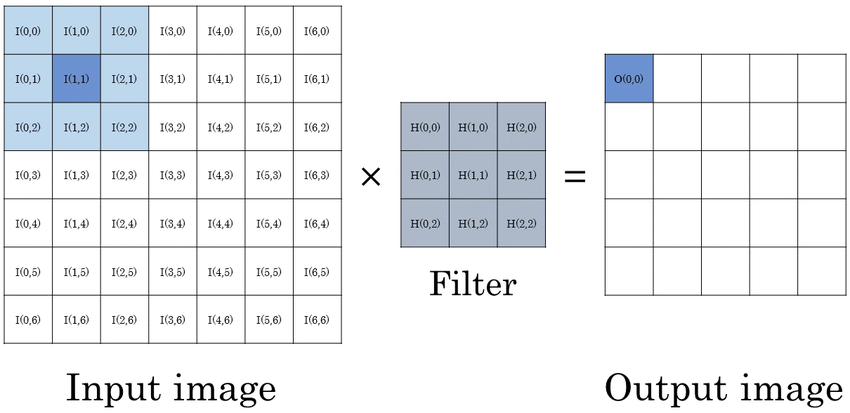

Output of a kernel: $y_i=\phi (b_i+\sum_{x_i \in x}W_{ij}x_i$) (Single channel and feature map)
* $W_{ij}$ are the weights of the kernel
* $\phi$ is the activation function

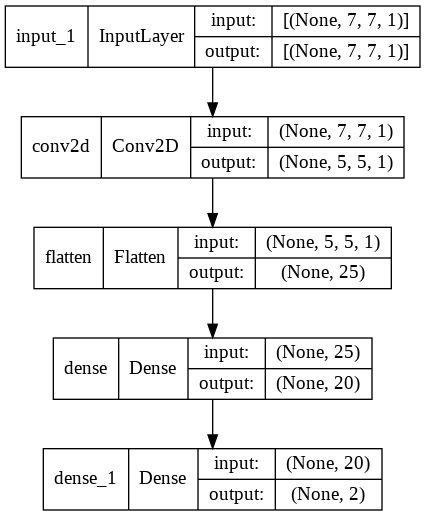

In [ ]:
#Input image is 7x7
input = Input(shape=(7,7,1))

#3x3 convolution (only one feature map or filter)
conv2d = Conv2D(filters=1,
                kernel_size=3,
                padding='valid',
                activation='relu')(input)
#Flatten output and connect to a dense layer with binary output
flatten = Flatten()(conv2d)
dense = Dense(units=20,activation='relu')(flatten)
output = Dense(2, activation='softmax')(dense)

#Save model and plot it
model = Model([input],output)
plot_model(model,show_shapes=True)

###The deeper the layer, the higher order the object it's learning is.

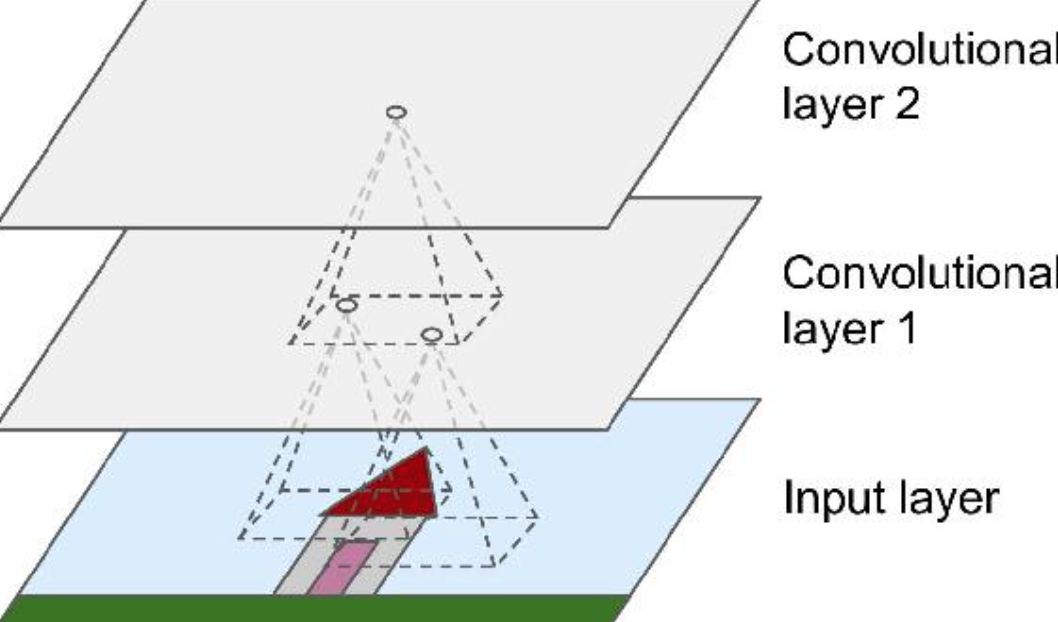

###Additional features maps are utilized to find additional features within the same layer!!
* Convolutions can use multiple filters called feature maps.
* Each feature map as a different set of weights and biases in same layer.

##Inception Layers

* Concatenated convolutions within a single layer are called inception layers.

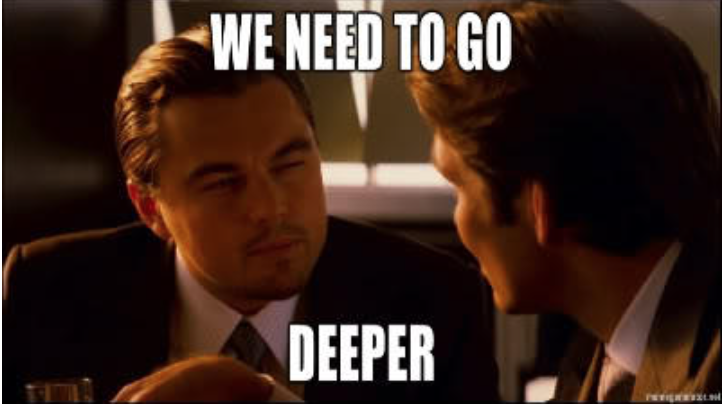



* Motivation is to incoperate more sparsity into the model allowing it to go deeper without increasing computation requirements.
* Computing infrastructures are
very inefficient when it comes to numerical calculation on
non-uniform sparse data structures. [1]
* The solution is to break the sparse matrices into smaller, denser submatrices

###Architecture
* Duplicates previous layer into the four inputs shown below.
* Concatenates outputs of all layers in filter concatenation
  * Note that the 3$\times$3 maxpooling layer doesn't reduce the dimensionality if stride = 1.

###Naive inception layer

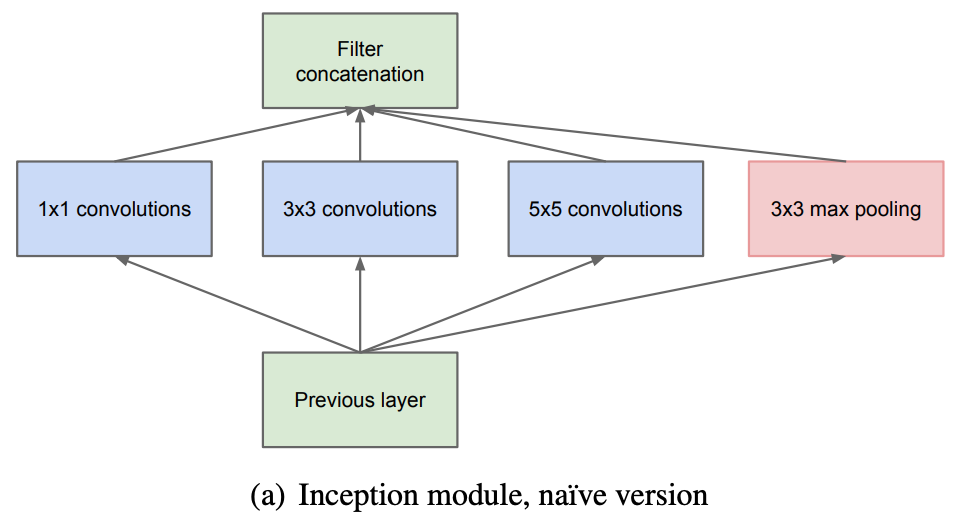

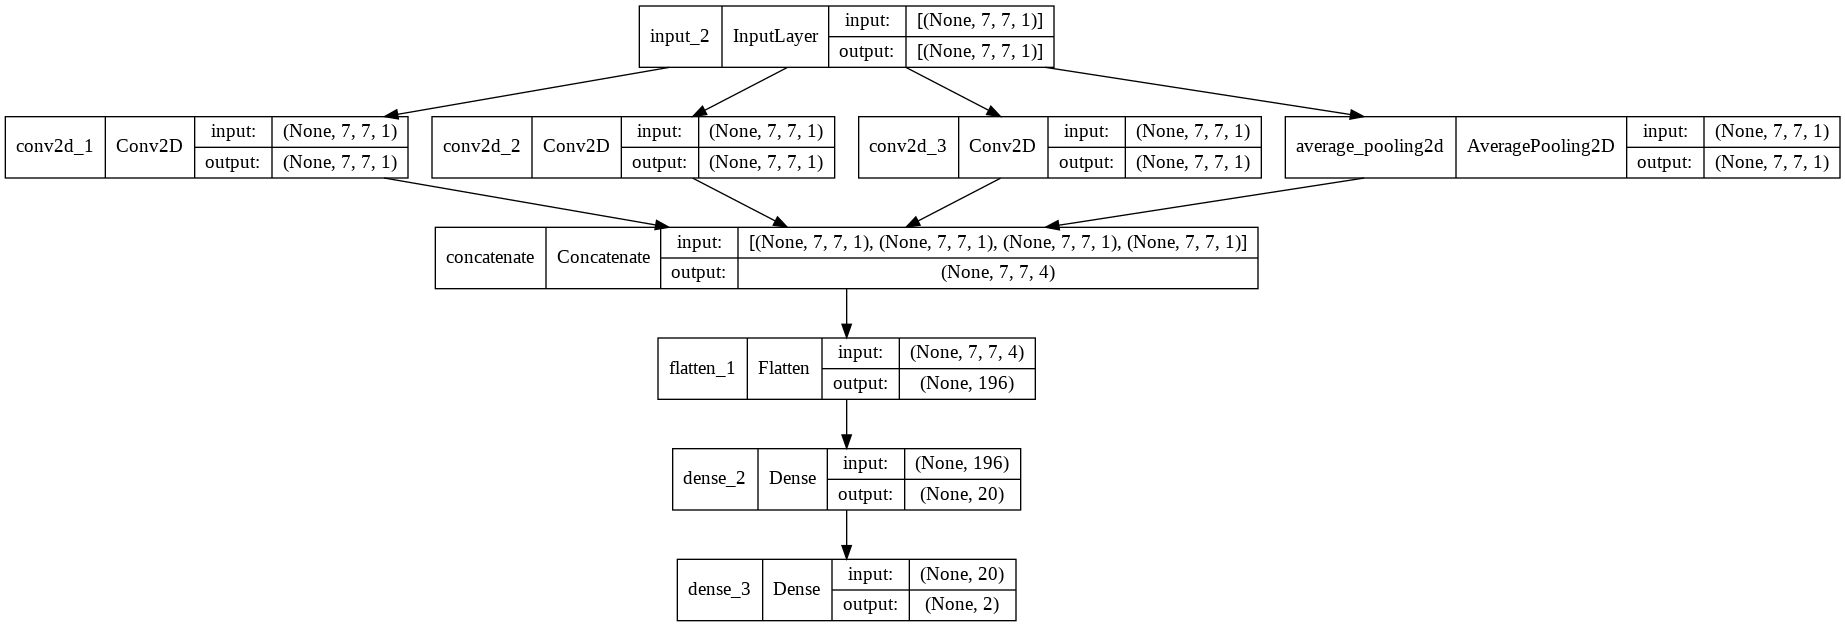

In [ ]:
#Input image is 7x7
input = Input(shape=(7,7,1))

#Naive Inception (only one feature map or filter)
inception_naive = naive_inception(input,filter_sizes=[1,1,1])
#Flatten output and connect to a dense layer with binary output
flatten = Flatten()(inception_naive)
dense = Dense(units=20,activation='relu')(flatten)
output = Dense(2, activation='softmax')(dense)

#Save model and plot it
model = Model([input],output)
plot_model(model,show_shapes=True)

###Inception layer

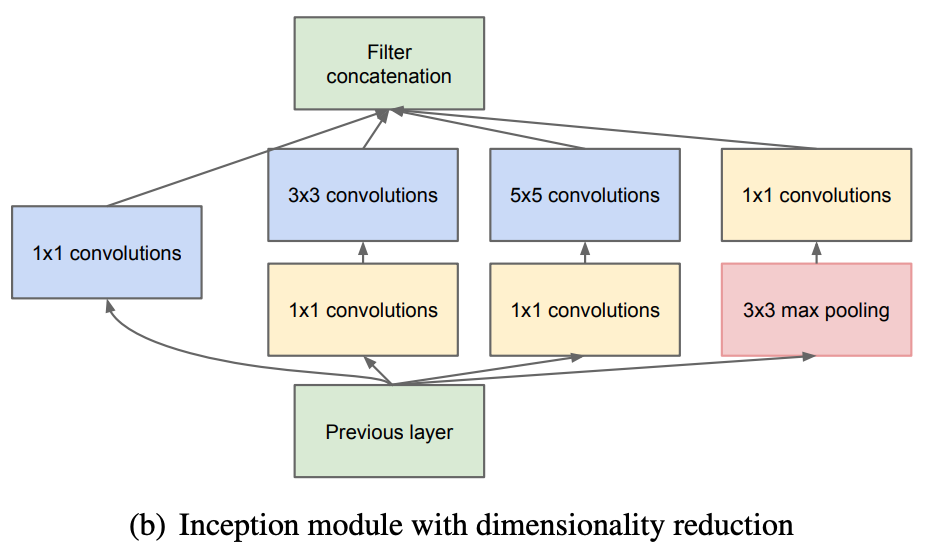

1$\times$1 kernel
* Utilized for "dimensionality reduction", allows networks to grow larger without computational bottlenecks [1].
* Decreases computational power of successive 3$\times$3 and 5$\times$5 kernels.

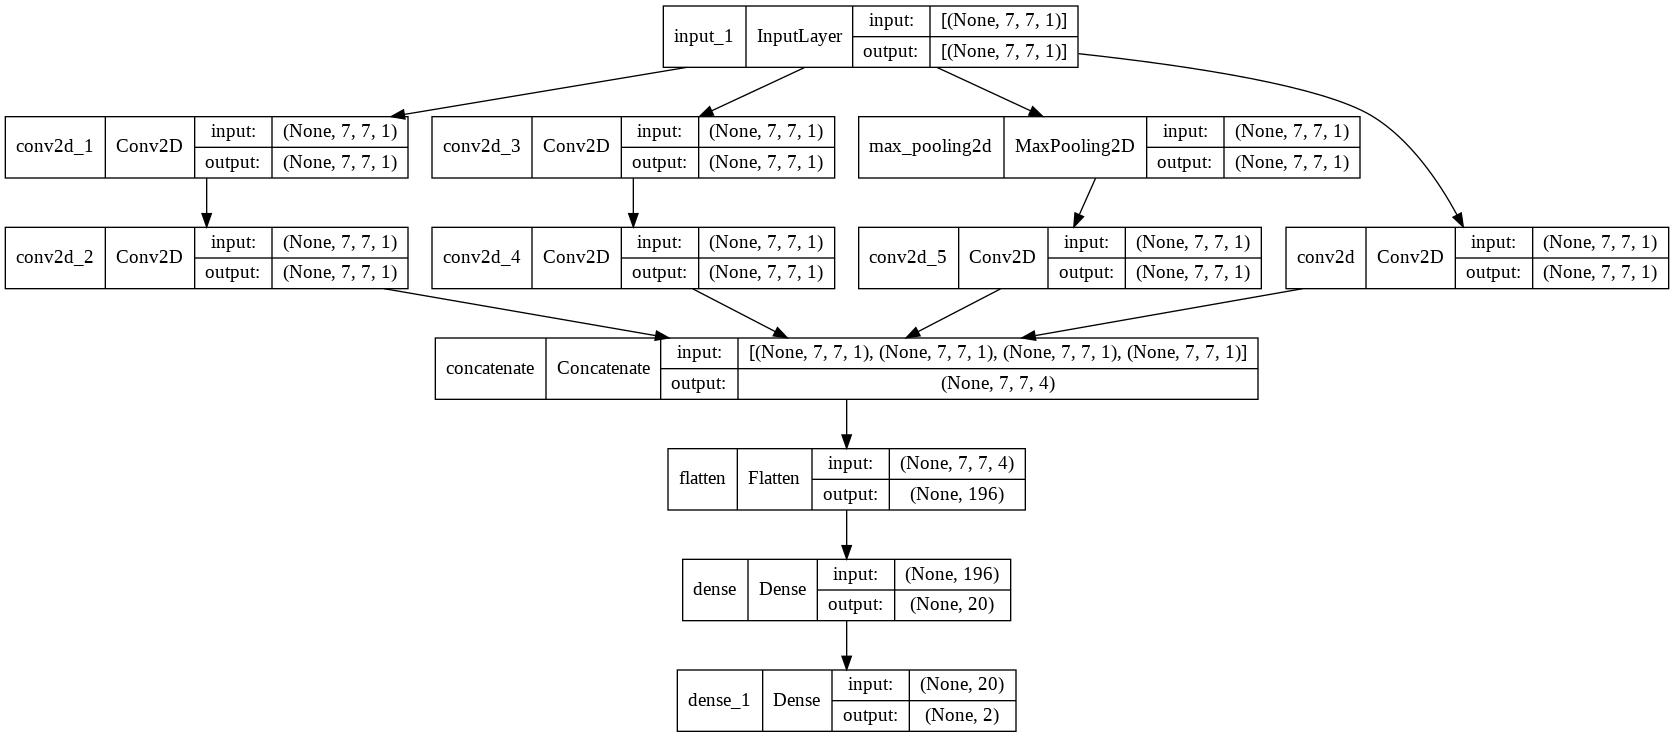

In [96]:
#Input image is 7x7
input = Input(shape=(7,7,1))

#Naive Inception (only one feature map or filter)
inception2d = inception(input,filter_sizes=[1,1,1])
#Flatten output and connect to a dense layer with binary output
flatten = Flatten()(inception2d)
dense = Dense(units=20,activation='relu')(flatten)
output = Dense(2, activation='softmax')(dense)

#Save model and plot it
model = Model([input],output)
plot_model(model,show_shapes=True)

##GoogleNet [1]

* Implementation of inceptions for 224$\times$224$\times$3 image
* Used in ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2014 competition and won!!

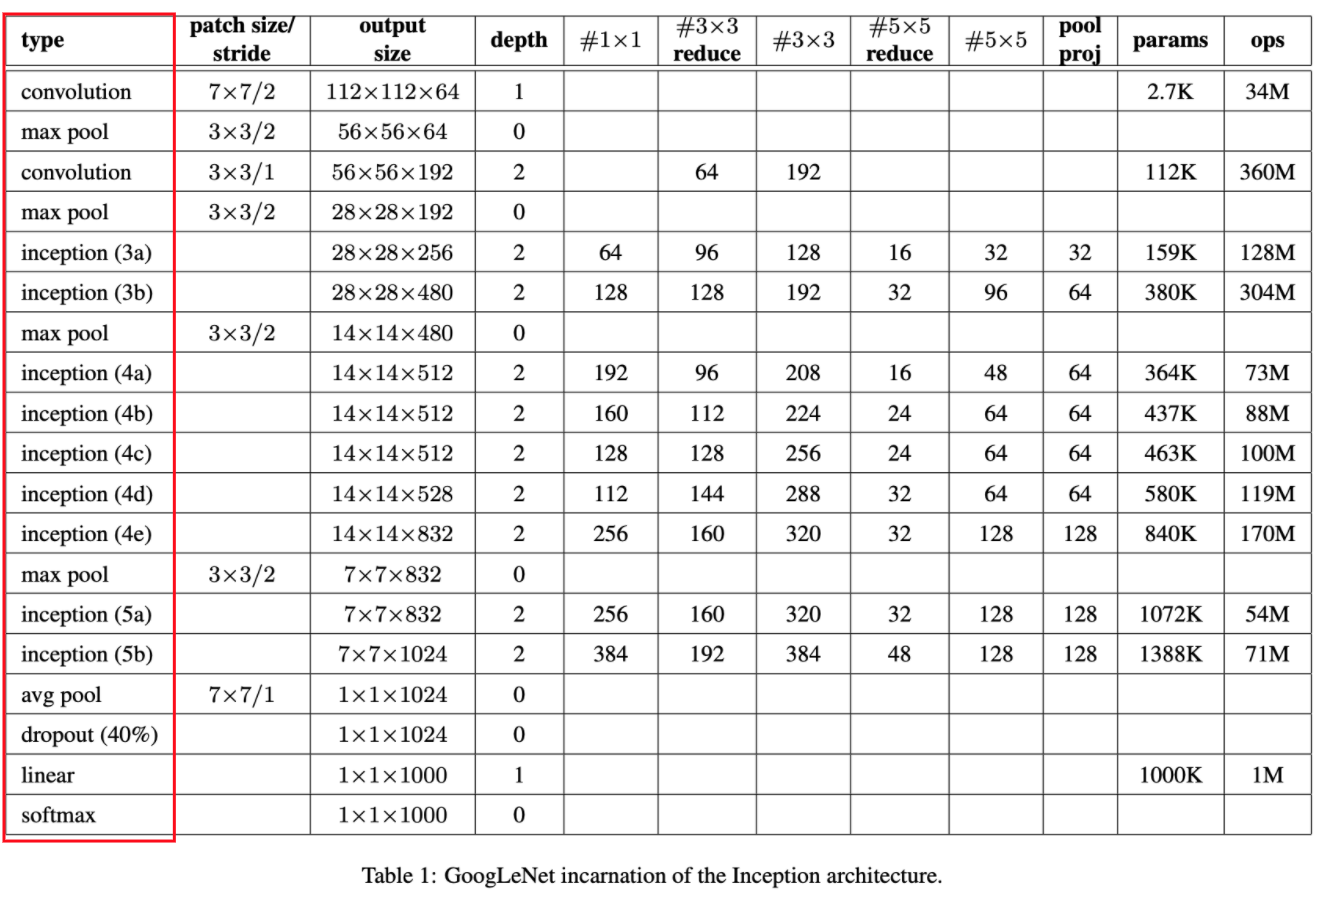

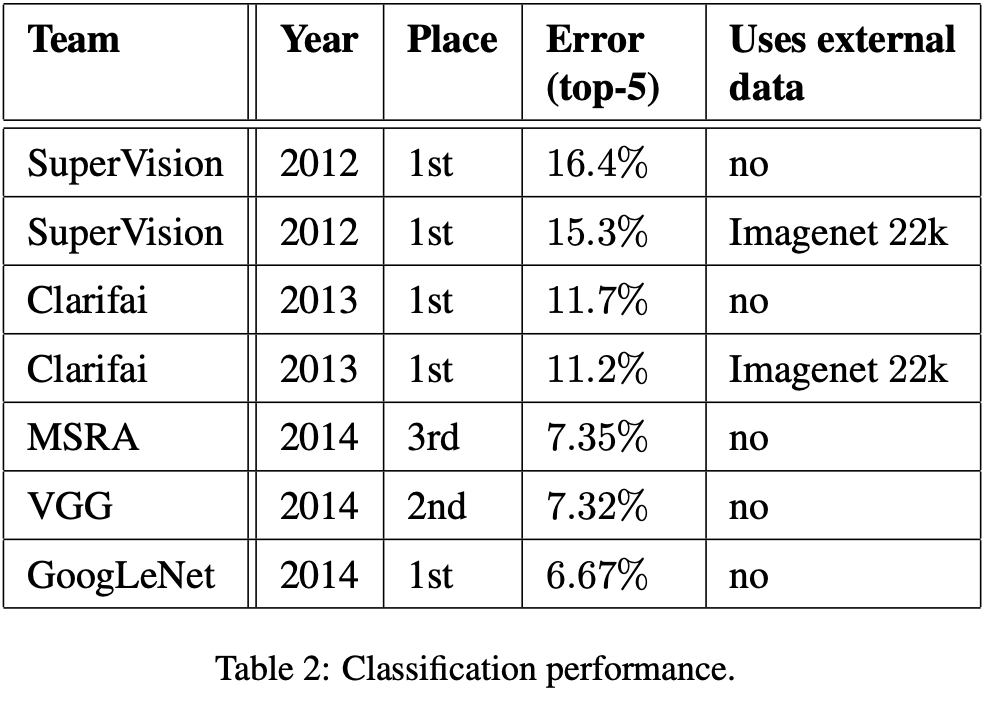

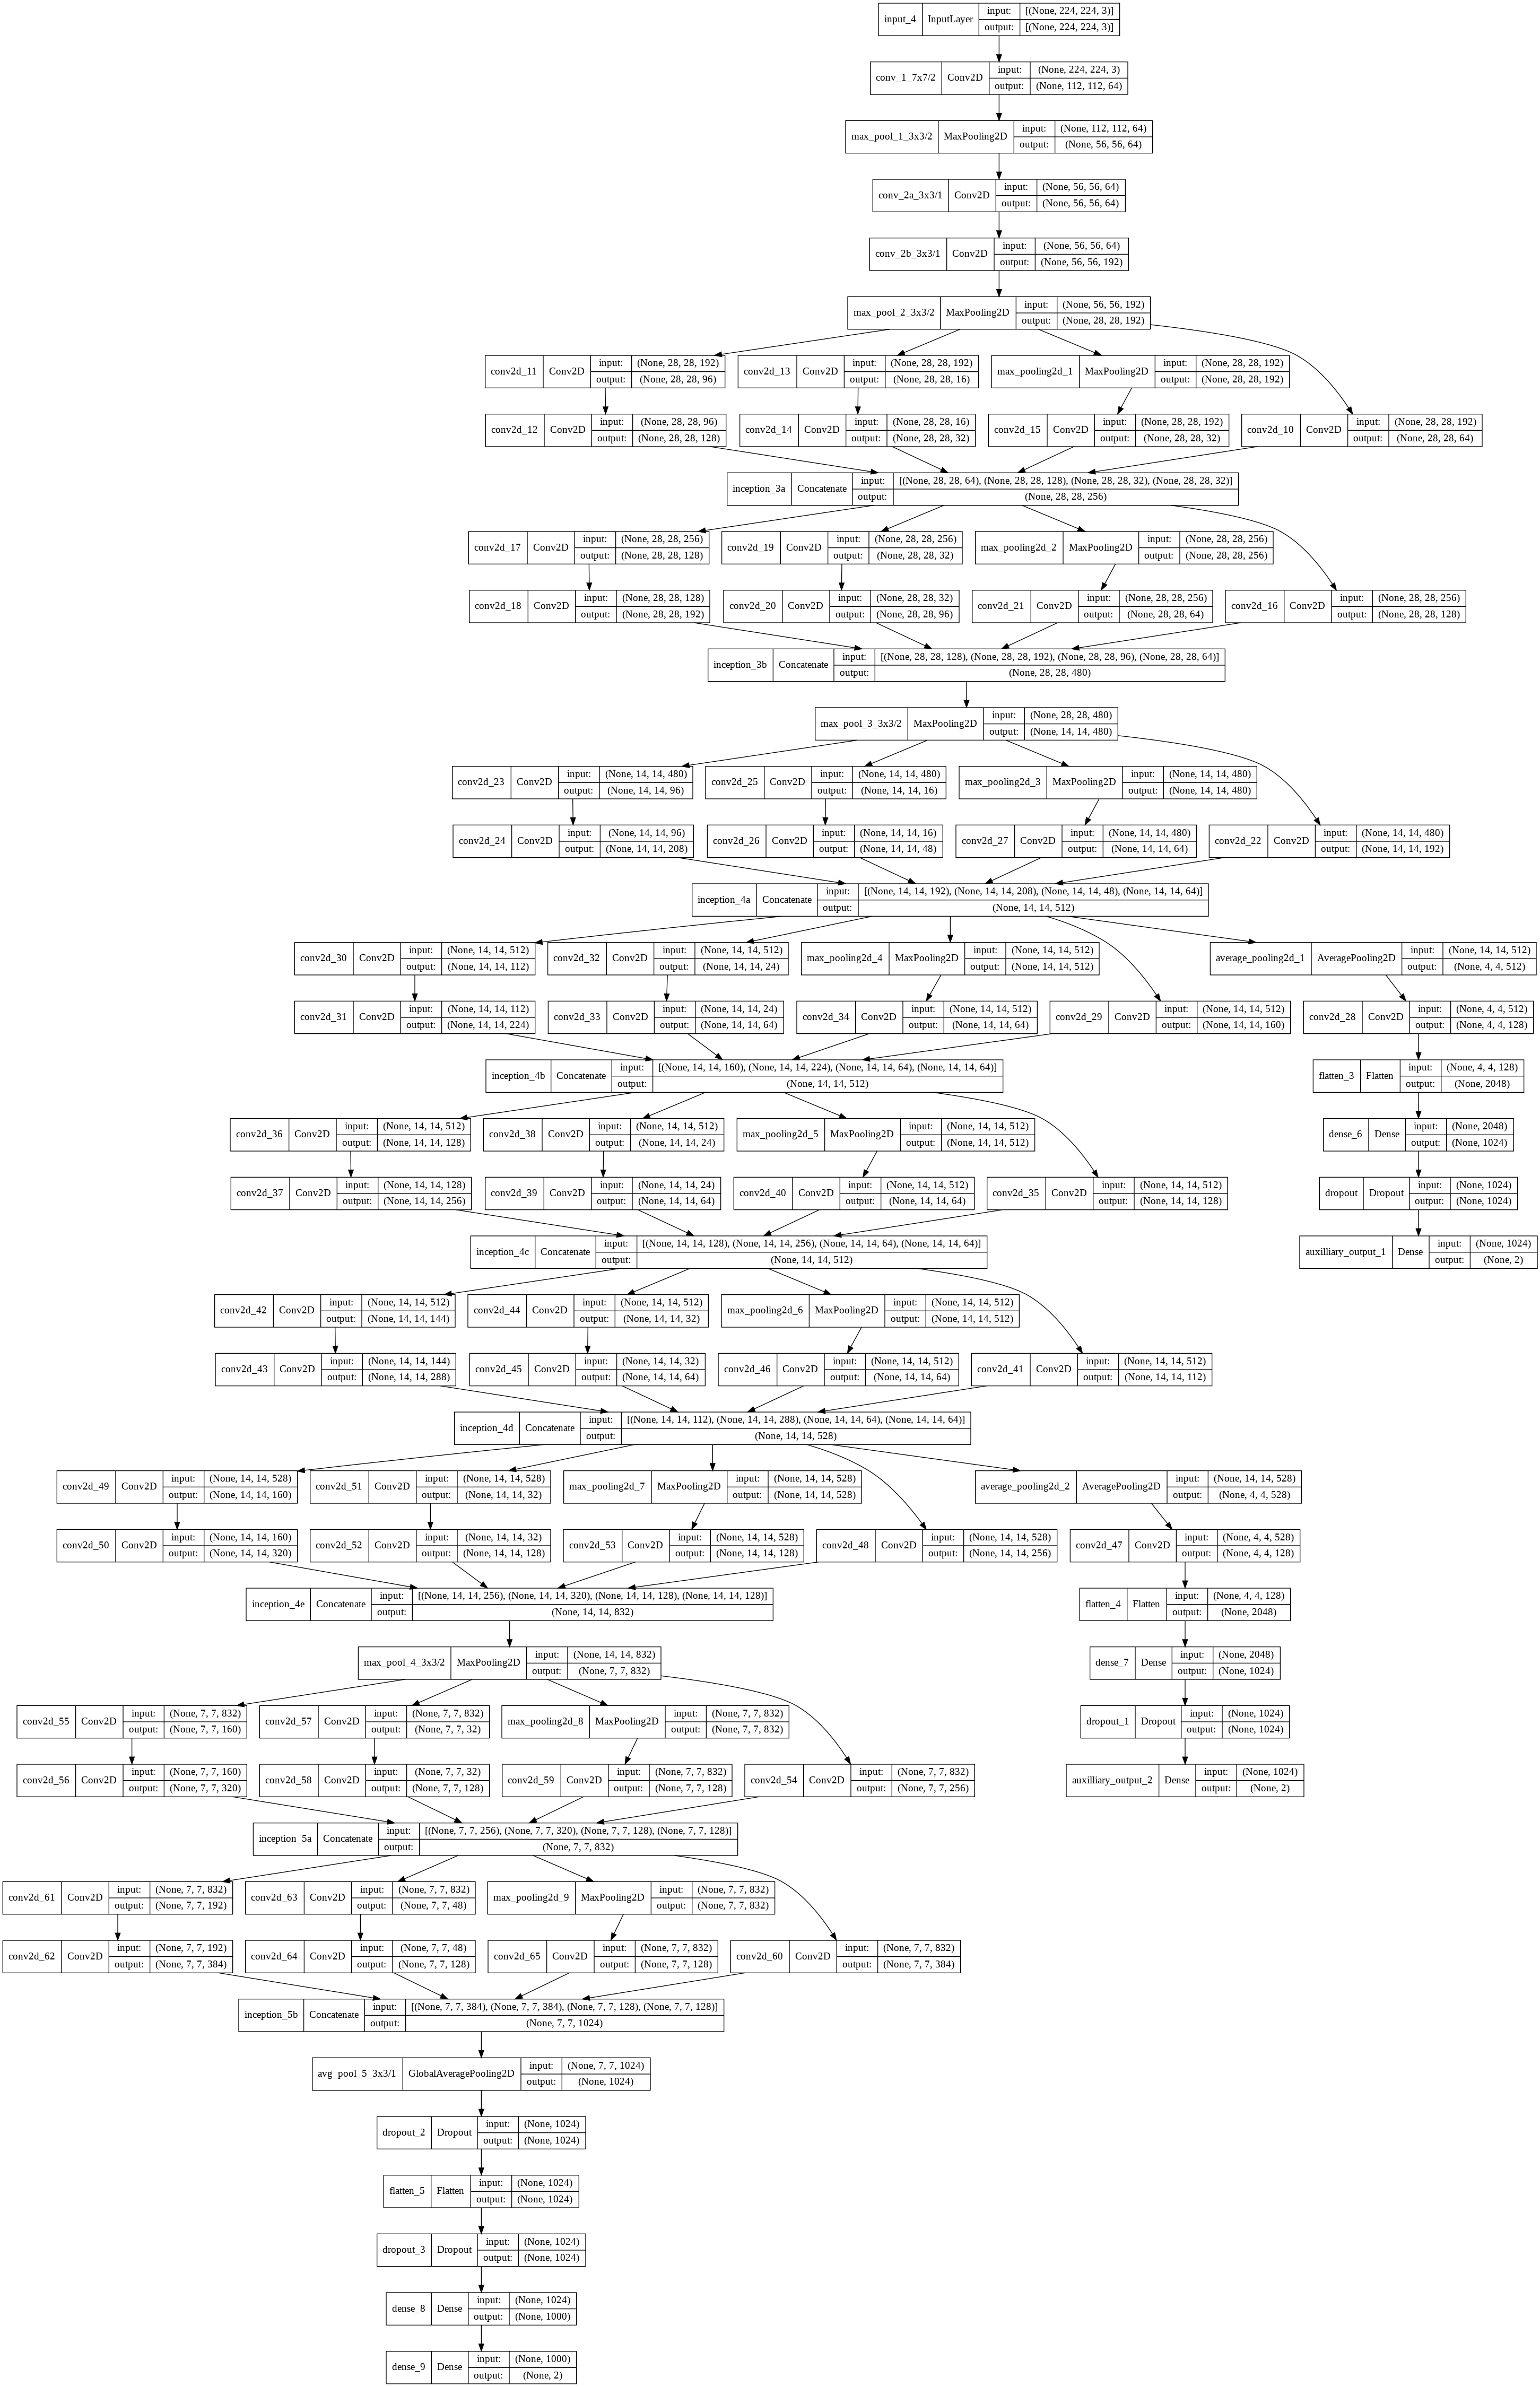

In [ ]:
#Layer initializers
kernel_init=TruncatedNormal(mean=0., stddev=1.)
bias_init=Constant(value=0.2)

#Input image is 224x224x3
input = Input(shape=(224,224,3))
model = googlenet(input) #Cite this
plot_model(model,show_shapes=True)

## Problem Statement and Dataset

*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to develop a model which classifies electron and photon electromagnetic showers as accurately as possible based on the detector images provided in the dataset below (one pixel = one channel of the detector)
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.
*   Although we are using Keras Framework in this sample notebook, you are free to choose Machine Learning / Deep Learning Framework of your choice. 

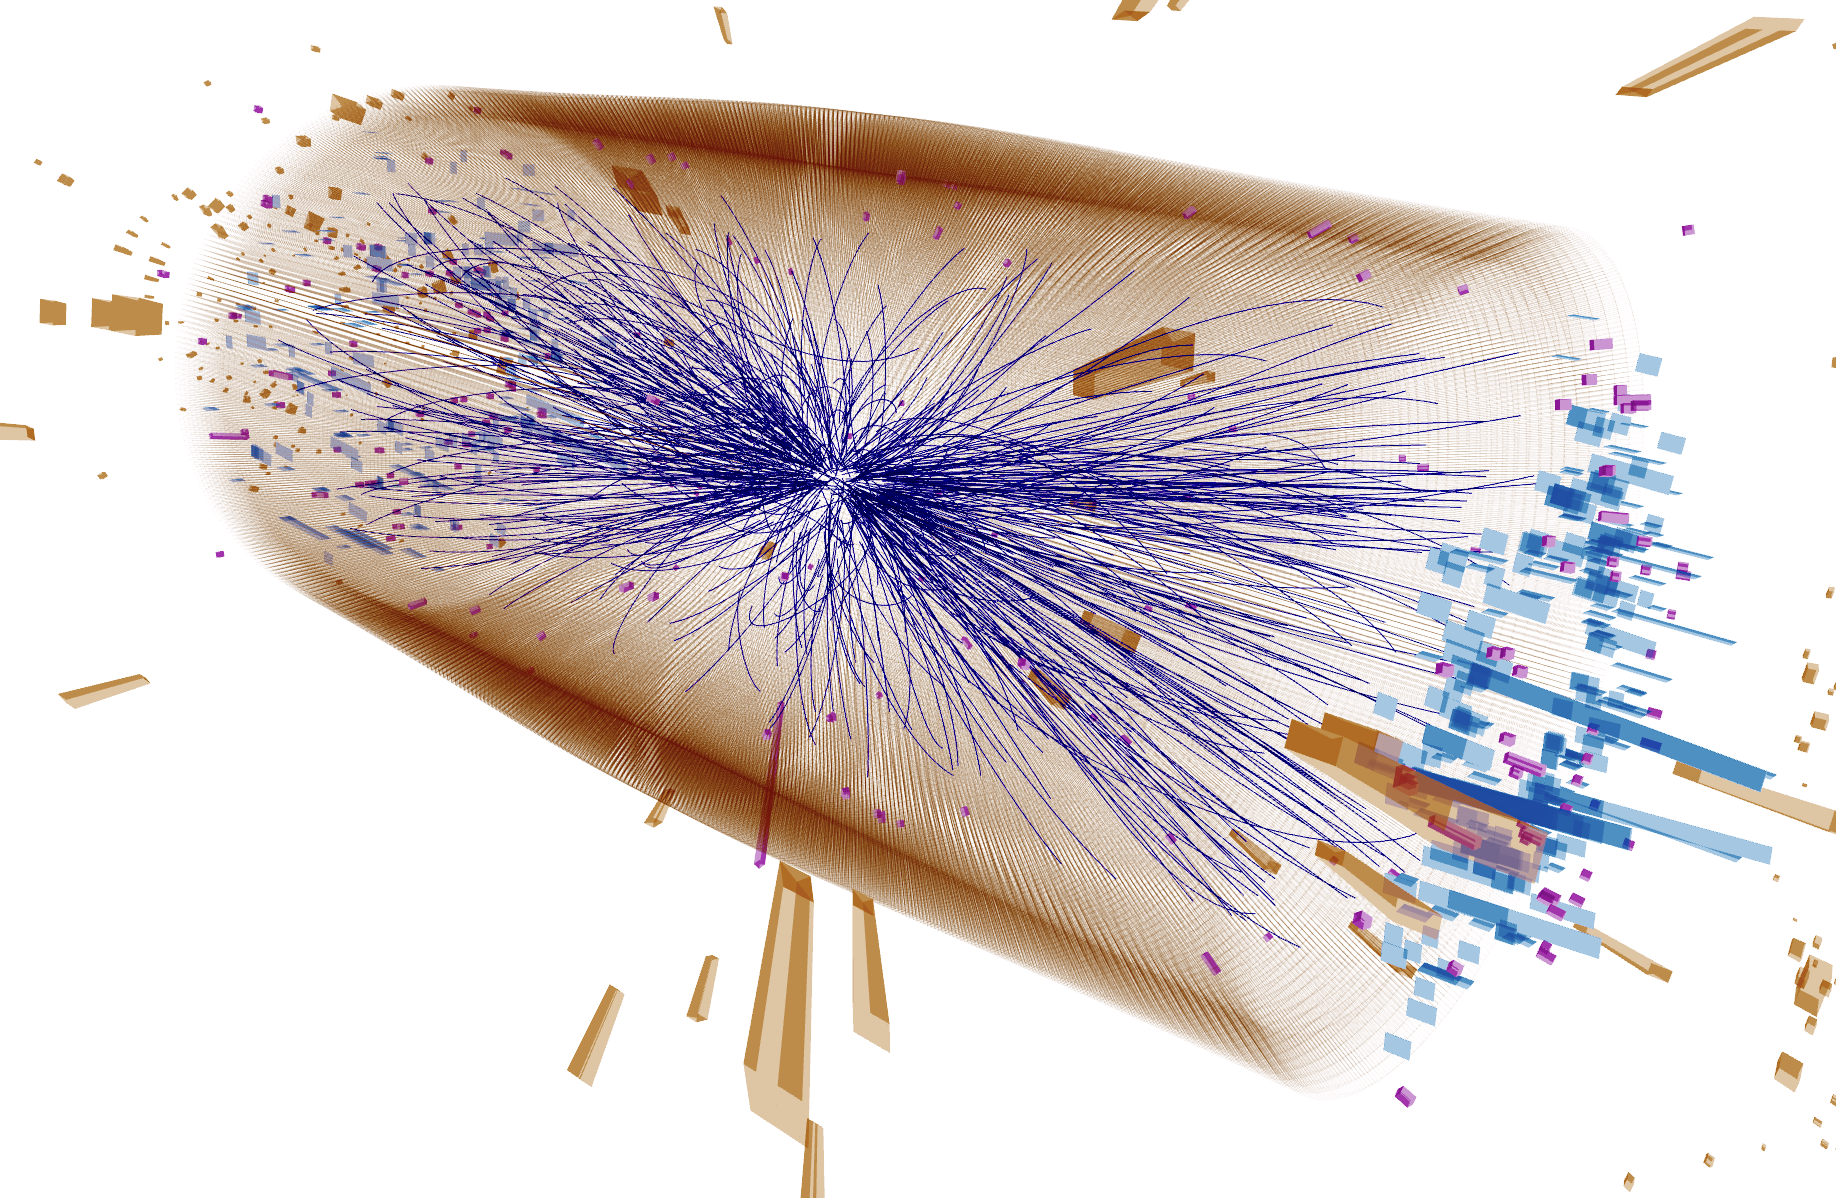

####Single photon and electron event
Each pixel in the image corresponds to a detector cell, while the intensity of the pixel corresponds to how much energy is measured in that cell. Timing of the energy deposits are also available, though this may or may not be relevant. The dataset contains 32x32 Images of the energy hits and their timing (channel 1: hit energy and channel 2: its timing) in each calorimeter cell (one cell = one pixel) for the two classes of particles: Electrons and Photons. The dataset contains around four hundred thousand images for electrons and photons.

In [ ]:
X_train.shape,y_train.shape

((40000, 32, 32, 2), (40000,))

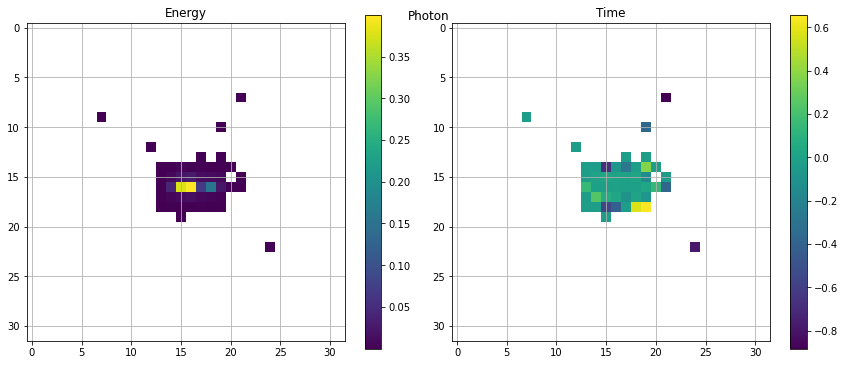

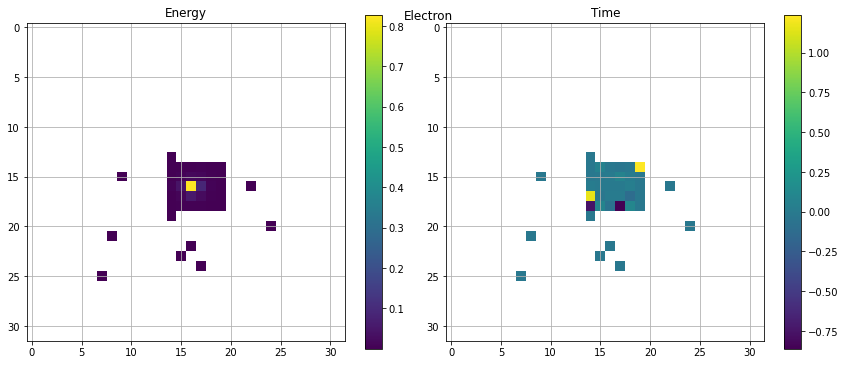

In [ ]:
plot_event(remove_empty_pixels(X_train),y_train)
plot_event(remove_empty_pixels(X_train),y_train,event=-1)

####Average photon and electron event

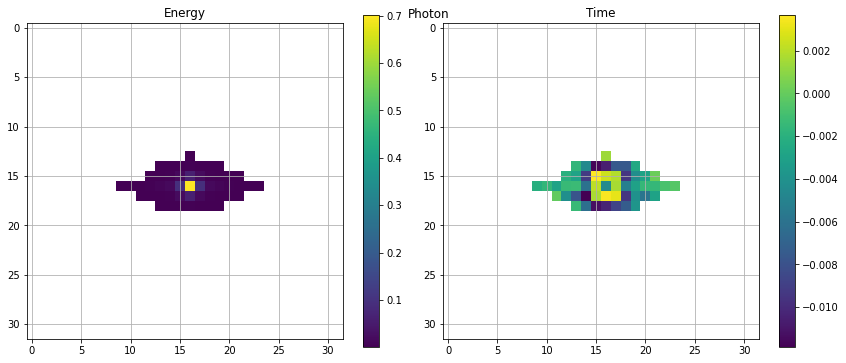

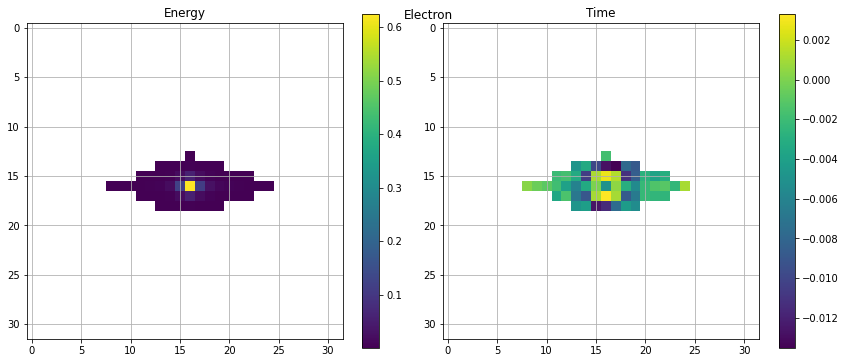

In [ ]:
plot_event(remove_empty_pixels(ph_X_mean,low_e=5e-4),[0])
plot_event(remove_empty_pixels(el_X_mean,low_e=5e-4),[1])

####3D scatterplot of average electron and photon hit

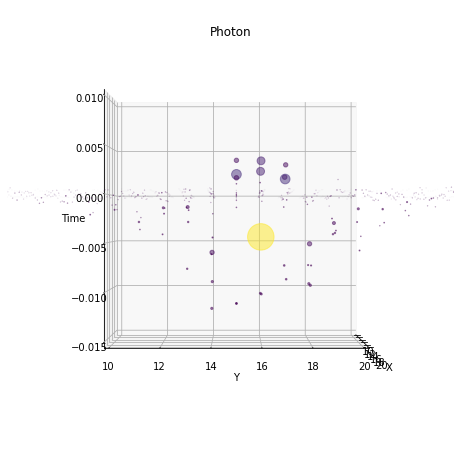

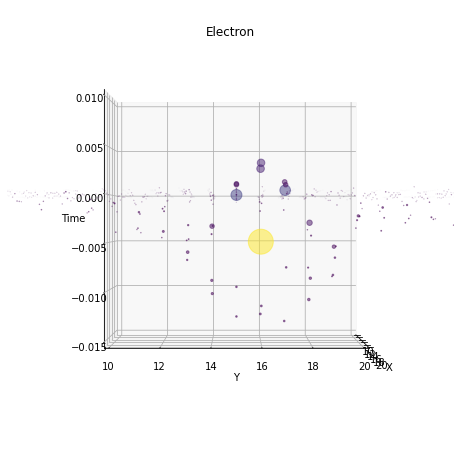

In [ ]:
%matplotlib inline
plot_spacetime(ph_X_mean,[0]);
plot_spacetime(el_X_mean,[1]);

##BearNet


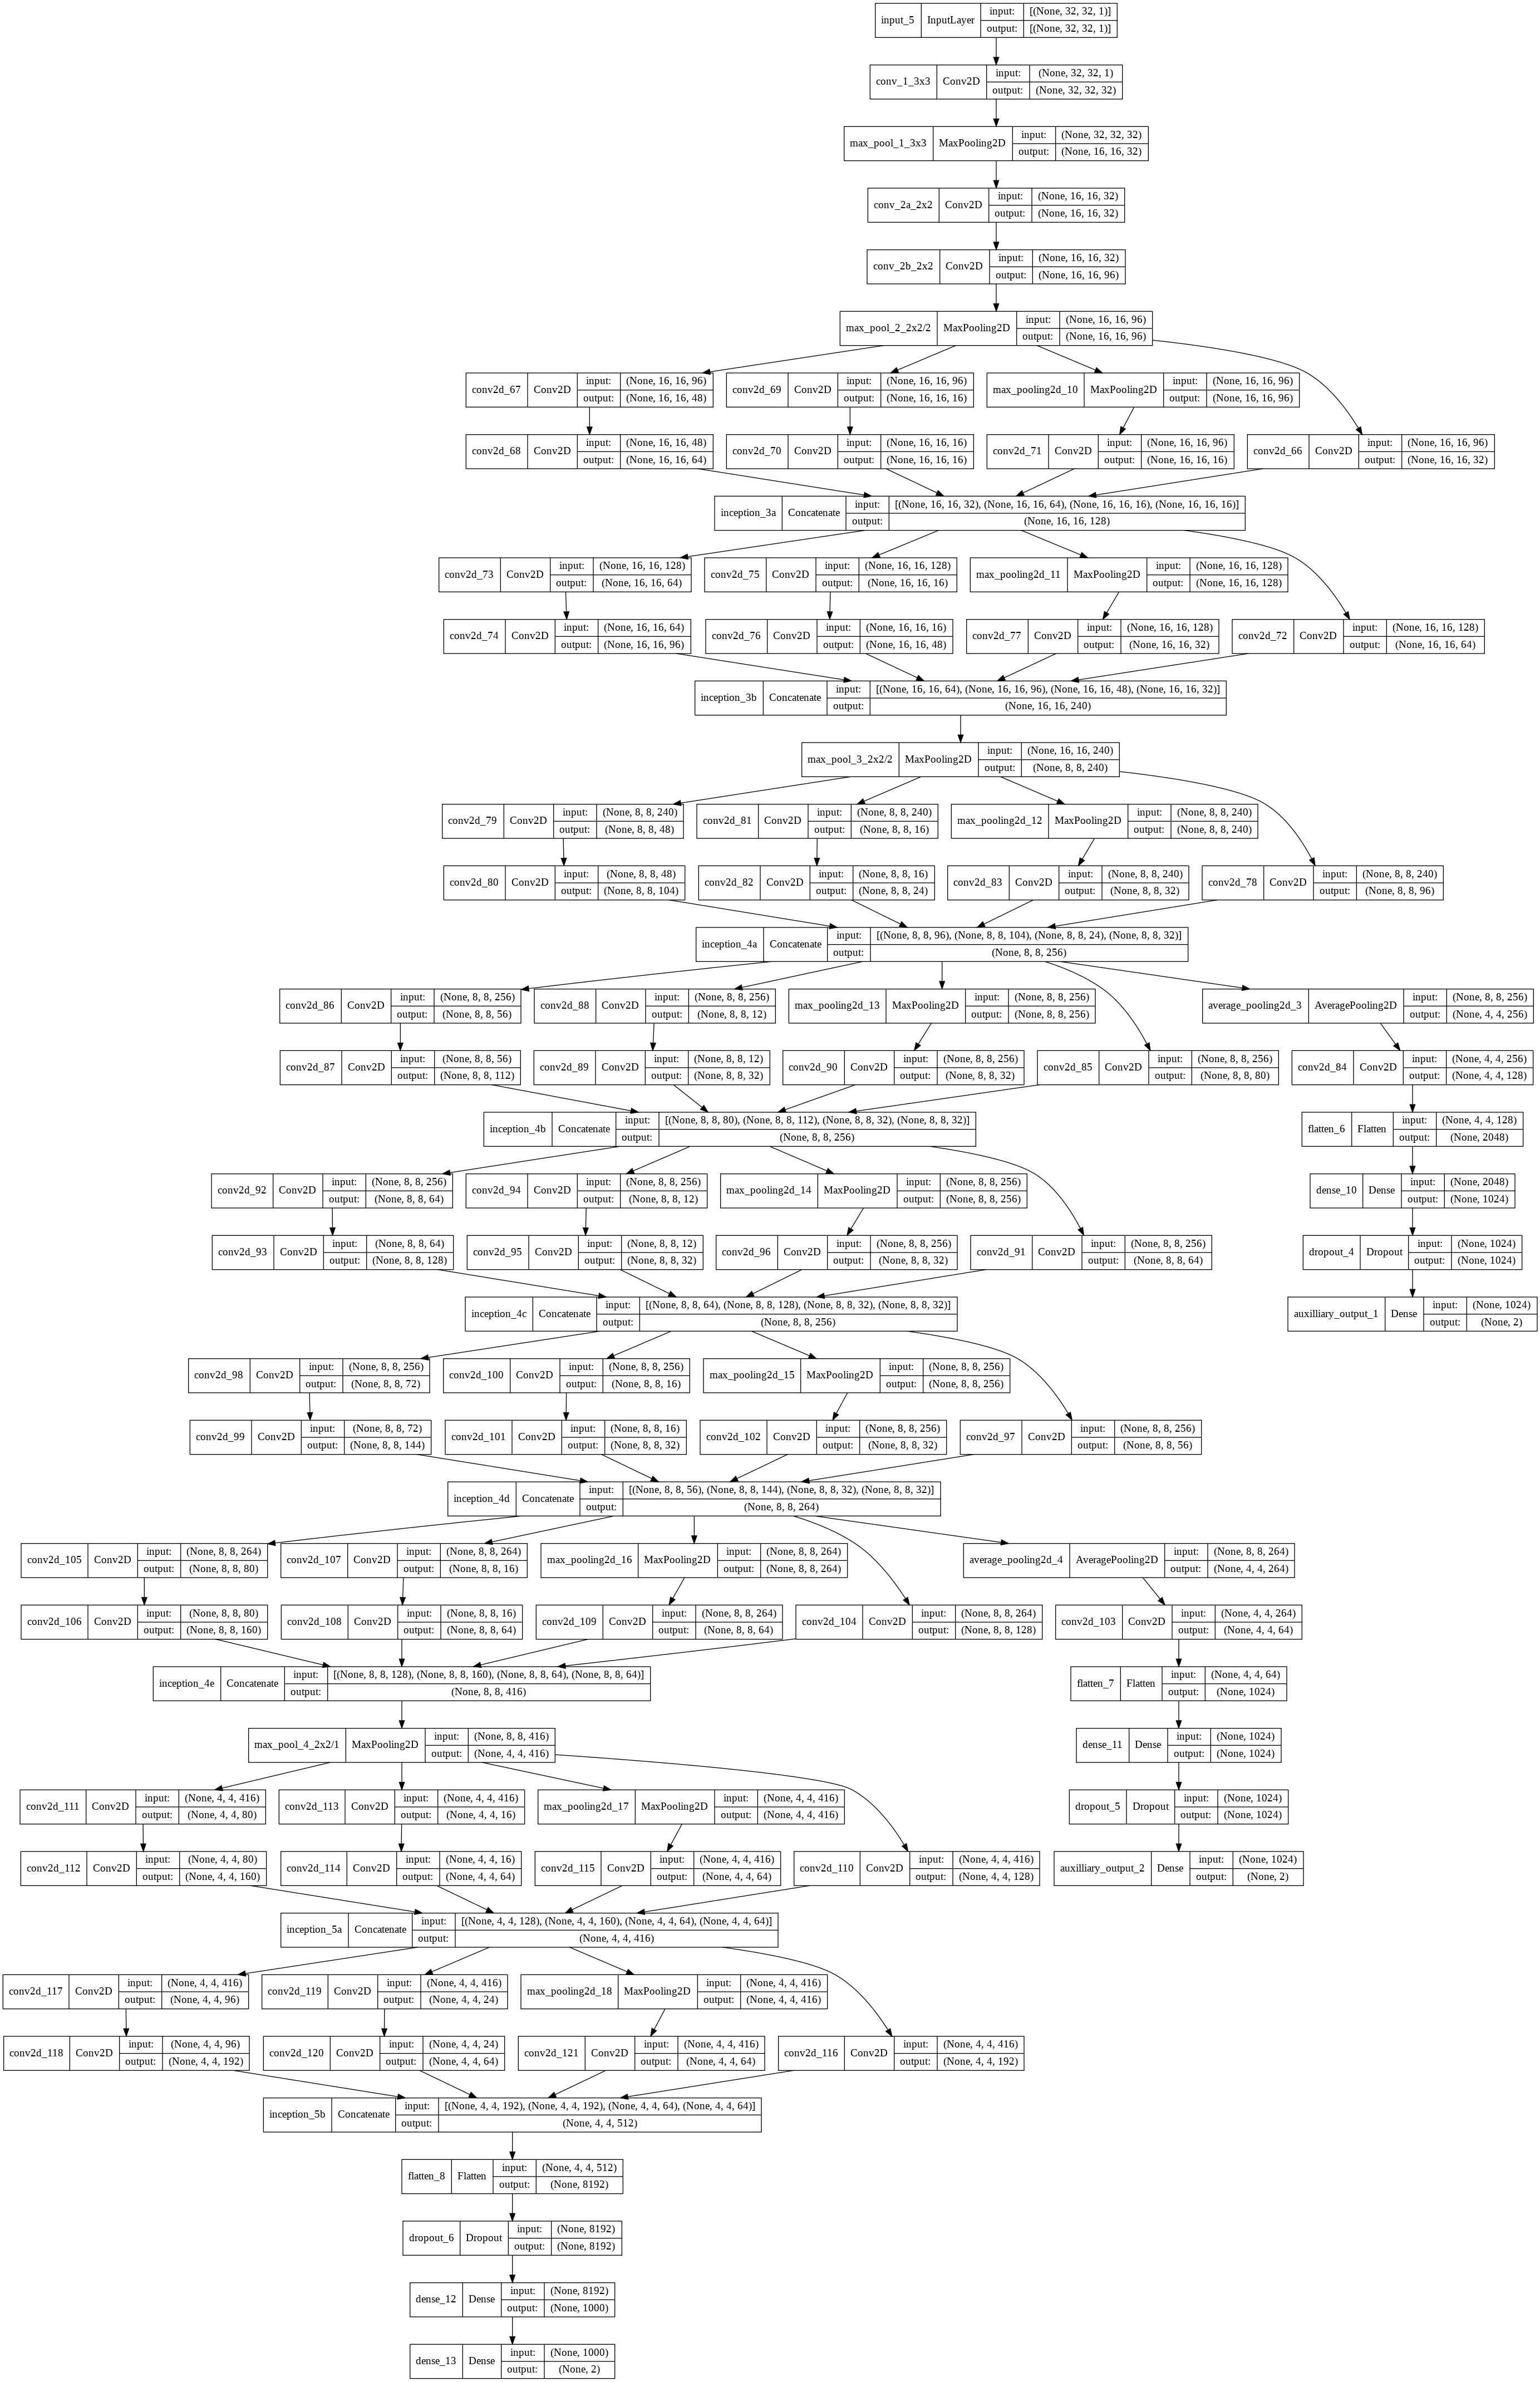

In [ ]:
#Layer initializers
kernel_init='TruncatedNormal'
bias_init=Constant(value=5e-4)

#Input image is 32x32
input = Input(shape=(32,32,1))
model = bearnet(input) #Cite this
plot_model(model,show_shapes=True)

In [ ]:
#Compile model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
checkpoint_cb = ModelCheckpoint("bearnet.h5", save_best_only=True)

model.compile(loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy'],loss_weights=[1,0.3,0.3], optimizer=Adam(learning_rate=lr_init), metrics=['accuracy'])

In [ ]:
#Train model
epochs = 20
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train[:,:,:,0], y_b_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(X_valid[:,:,:,0], y_b_valid),
                  callbacks=[reduce_lr,checkpoint_cb,TqdmCallback(verbose=2)],
                  verbose=0, shuffle=True)

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

  0%|          | 0.00/80.0 [00:00<?, ?batch/s]

In [80]:
model = load_model('gdrive/MyDrive/Classes/Fall21/PHY7097 ML/Final Project/model/bearnet-truncated')
with open('gdrive/MyDrive/Classes/Fall21/PHY7097 ML/Final Project/model/bearnet-truncated/history.pkl','rb') as f_history: history = pickle.load(f_history)

###Results

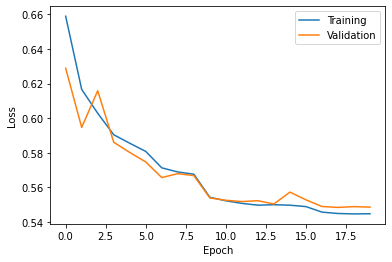

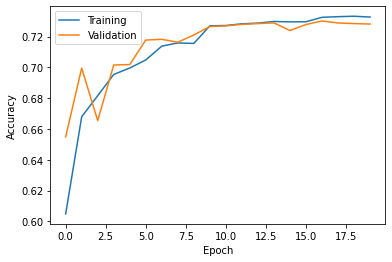

In [89]:
plot_history(history,metric='loss',save=False)
plot_history(history,metric='accuracy',save=False)

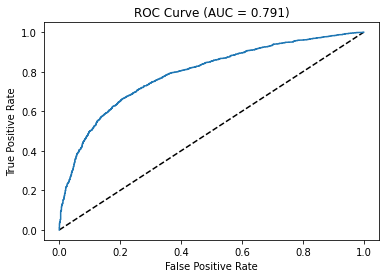

In [94]:
plot_roc(y_b_test[:,0],model.predict(X_test[:,:,:,0])[:,0],save=False)

##Conclusion
* Inception layers allow for deeper neural networks without compromising on computing power performance.

##References
* https://www.researchgate.net/figure/Image-convolution-with-an-input-image-of-size-7-7-and-a-filter-kernel-of-size-3-3_fig1_318849314
* https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf
* https://www.sciencedirect.com/topics/engineering/convolutional-layer
* https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/